# Train diabetes classification model

This notebook reads a CSV file and trains a model to predict diabetes in patients. The data is already preprocessed and requires no feature engineering.

The evaluation methods were used during experimentation to decide whether the model was accurate enough. Moving forward, there's a preference to use the autolog feature of MLflow to more easily deploy the model later on.

## Read data from local file



In [1]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient, Input, Output, command, dsl
from azure.ai.ml.entities import CommandComponent, Environment, PipelineJob
from azure.ai.ml.constants import AssetTypes
import os

In [2]:
try:
    credential = DefaultAzureCredential()
    ml_client = MLClient(
        credential,
        subscription_id="f4d87b2a-842e-44ff-96e4-4f8454c0bbd6", # Remplacez par votre ID d'abonnement
        resource_group_name="RGAML1", # Remplacez par votre groupe de ressources
        workspace_name="AML_W" # Remplacez par le nom de votre workspace
    )
    print("Connexion à Azure ML établie.")
except Exception as e:
    print(f"Erreur de connexion à Azure ML: {e}")

Connexion à Azure ML établie.


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('./data/diabetes-dev.csv')

In [4]:
df

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1142956,1,78,41,33,311,50.796392,0.420804,24,0
1,1823377,0,116,92,16,184,18.603630,0.131156,22,0
2,1916381,8,171,42,29,160,35.482247,0.082671,22,1
3,1247480,3,108,63,45,297,49.375169,0.100979,46,1
4,1516947,8,153,99,15,41,35.062139,0.116191,22,1
...,...,...,...,...,...,...,...,...,...,...
4995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
4996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
4997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
4998,1099353,0,132,98,18,161,19.791645,0.302257,23,0


## Split data

In [5]:
X, y = df[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, df['Diabetic'].values

In [6]:
len(X)

5000

In [7]:
import numpy as np

In [8]:
print(np.unique(y, return_counts=True))

(array([0, 1]), array([3344, 1656]))


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

## Train model

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
model = LogisticRegression(C=1/0.1, solver="liblinear").fit(X_train, y_train)

## Evaluate model

In [13]:
import numpy as np

In [14]:
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)

In [15]:
acc

0.7906666666666666

In [16]:
from sklearn.metrics import roc_auc_score

In [17]:
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])

In [18]:
auc

0.8535537676609105

In [19]:

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'ROC Curve')

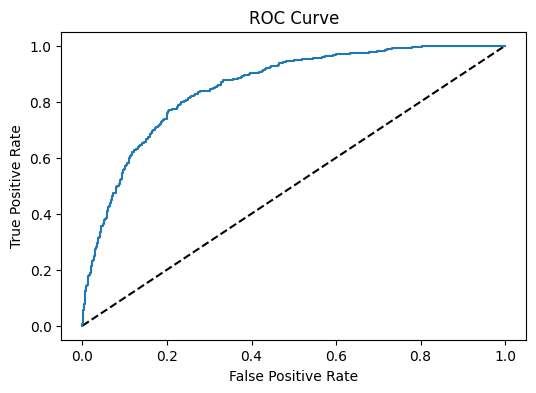

In [20]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
fig = plt.figure(figsize=(6, 4))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [ ]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

my_path = './data/'

my_data = Data(
    path=my_path,
    type=AssetTypes.URI_FILE,
    description="<description>",
    name="<name>",
    version="<version>"
)

ml_client.data.create_or_update(my_data)

In [18]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient, load_job


# Charger le YAML et soumettre
job = load_job(source="../src/job.yml")
returned_job = ml_client.jobs.create_or_update(job)
print("Job name:", returned_job.name)
print("Status:", returned_job.status)


Uploading model (0.0 MBs): 100%|██████████| 2327/2327 [00:00<00:00, 27875.54it/s]




Job name: blue_ring_szrb4gc9zh
Status: Starting
